# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Load the Data/Filtering for Chosen Zipcodes

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-online-ds-ft-100719/master/zillow_data.csv')#'zillow_data.csv')
#'zillow_data.csv')

In [ ]:
df.head()

In [ ]:
# grab single zip code
df_kc = df[df['RegionName'] == 64154]

In [ ]:
df_kc.head()

# Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro',
                                  'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [ ]:
df_kc_melt = melt_data(df_kc)

In [ ]:
df_kc_melt.head()

# ARIMA Modeling

Code from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [ ]:
def timed(fn):
    """From online-ds-ft-100718 bonus study group: pythond deep dive"""
    from time import perf_counter
    from functools import wraps
    
    def get_now(return_dt = True, return_str=True, show=False):
        import datetime as dt
        import tzlocal as tz
        now=dt.datetime.now(tz=tz.get_localzone())
        str_time =now.strftime('%m/%d/%Y - %I:%M:%S %p')
        if show:
            print(str_time)

        output=[]
        if return_dt:
            output.append(now)

        if return_str:
            output.append(str_time)
        return output[:]
    
    
    @wraps(fn)
    def inner(*args,**kwargs):
        
        start_str = get_now(return_dt=False,return_str=True,show=False)
        print(f'[i] STARTING GRID SEARCH @ {start_str}:')

        start = perf_counter()
        
        result = fn(*args, **kwargs)
        
        end = perf_counter()
        elapsed = end-start
        
        arg_str = [str(a) for a in args]
        kwarg_str = [f"{k}={v}" for  k,v in kwargs.items()]
        
        all_args = arg_str + kwarg_str
        args_str_out = ','.join(all_args)
        
        end_str = get_now(return_dt=False, return_str=True)
#         print(f"[i] GRID SEARCH FINISHED AT {end_str}")        
        print(f"{fn.__name__}({args_str_out}) took {elapsed:.6f}")
        return result
    return inner


In [ ]:
df_kc_melt.plot()

In [ ]:
ts = df_kc_melt

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts)
fig = decomp.plot();
fig.set_size_inches(12,8)

In [ ]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
#     import pdb
#     pdb.set_trace()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
@timed
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [15]:
# evaluate parameters
p_values = [0, 1, 3, 8]
d_values = [1]
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_kc_melt.values, p_values, d_values, q_values)

[i] STARTING GRID SEARCH @ ['01/07/2020 - 12:18:54 PM']:
ARIMA(0, 1, 0) MSE=2455815.101
ARIMA(0, 1, 1) MSE=808446.950
ARIMA(1, 1, 0) MSE=905910.803
ARIMA(1, 1, 2) MSE=461003.943
ARIMA(3, 1, 0) MSE=555607.463
ARIMA(3, 1, 1) MSE=486312.669
ARIMA(8, 1, 0) MSE=524305.631
ARIMA(8, 1, 1) MSE=533486.667
Best ARIMA(1, 1, 2) MSE=461003.943
evaluate_models([[152600.]
 [152600.]
 [152700.]
 [152600.]
 [152500.]
 [152400.]
 [152300.]
 [152100.]
 [152000.]
 [151800.]
 [151700.]
 [151400.]
 [151100.]
 [150800.]
 [150600.]
 [150400.]
 [150300.]
 [150300.]
 [150400.]
 [150700.]
 [151200.]
 [151900.]
 [152600.]
 [153400.]
 [154400.]
 [155500.]
 [156800.]
 [158100.]
 [159400.]
 [160800.]
 [162200.]
 [163600.]
 [165100.]
 [166600.]
 [167900.]
 [169000.]
 [170100.]
 [171100.]
 [172000.]
 [172800.]
 [173600.]
 [174300.]
 [175000.]
 [175700.]
 [176500.]
 [177400.]
 [178200.]
 [178900.]
 [179600.]
 [180400.]
 [181200.]
 [181900.]
 [182700.]
 [183500.]
 [184300.]
 [185200.]
 [186100.]
 [187000.]
 [188000.]
 [

# Step 6: Interpreting Results

In [17]:
# make foreacst 
model = ARIMA(df_kc_melt, order=(1,1,2))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1963.765
Method:                       css-mle   S.D. of innovations            408.781
Date:                Tue, 07 Jan 2020   AIC                           3937.529
Time:                        12:25:24   BIC                           3955.409
Sample:                    05-01-1996   HQIC                          3944.714
                         - 04-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           366.9638    137.722      2.665      0.008      97.033     636.895
ar.L1.D.value     0.4727      0.069      6.840      0.000       0.337       0.608
ma.L1.D.value     1.3096      0.066     19.751      0.000       1.180       1.440
ma.L2.D.value     0.5957      0.070      8.511      0.000       0.458       0.733
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1155           +0.0000j            2.1155            0.0000
MA.1           -1.0993           -0.6859j            1.2957           -0.4112
MA.2           -1.0993           +0.6859j            1.2957            0.4112
-----------------------------------------------------------------------------
"""

In [18]:
forecast = model_fit.forecast(24)

In [22]:
forecast[0]

array([252581.58493821, 252184.14234056, 252189.7645576 , 252385.91903559,
       252672.13977872, 253000.9356326 , 253349.85711349, 253708.29215416,
       254071.2243377 , 254436.28235998, 254802.34528482, 255168.88323587,
       255535.64573598, 255902.51438238, 256269.43320506, 256636.37574651,
       257003.32950003, 257370.28855359, 257737.25011253, 258104.21285578,
       258471.17615887, 258838.13972659, 259205.10341941, 259572.06717137])

In [29]:
actual_foreacst = forecast[0]
forecast_conf_int = forecast[2]
forecast_conf_int

array([[251780.38802071, 253382.7818557 ],
       [249815.37020964, 254552.91447148],
       [248061.20312654, 256318.32598866],
       [246688.62227249, 258083.21579869],
       [245603.80295956, 259740.47659787],
       [244724.65880191, 261277.2124633 ],
       [243994.06555644, 262705.64867054],
       [243373.74041867, 264042.84388965],
       [242837.87554773, 265304.57312766],
       [242368.68768294, 266503.87703702],
       [241953.57502544, 267651.11554419],
       [241583.34176414, 268754.4247076 ],
       [241251.08612732, 269820.20534463],
       [240951.4934102 , 270853.53535455],
       [240680.37680813, 271858.48960199],
       [240434.37188257, 272838.37961045],
       [240210.72809211, 273795.93090795],
       [240007.16300977, 274733.41409741],
       [239821.75797615, 275652.74224891],
       [239652.88178679, 276555.54392477],
       [239499.13377867, 277443.21853907],
       [239359.30062838, 278316.9788248 ],
       [239232.32303438, 279177.88380445],
       [239

In [24]:
df_kc_melt.tail(2)

,value
time,
2018-03-01,254400.0
2018-04-01,253300.0


In [30]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

In [31]:
# combine raw data dataframe and forecast dataframe
df_new = pd.concat([df_kc_melt, df_forecast])

In [32]:
df_new.head()

,forecast,lower_bound,upper_bound,value
time,,,,
1996-04-01,NaN,NaN,NaN,152600.0
1996-05-01,NaN,NaN,NaN,152600.0
1996-06-01,NaN,NaN,NaN,152700.0
1996-07-01,NaN,NaN,NaN,152600.0
1996-08-01,NaN,NaN,NaN,152500.0


Text(0.5, 1.0, 'Forecast for 64154')

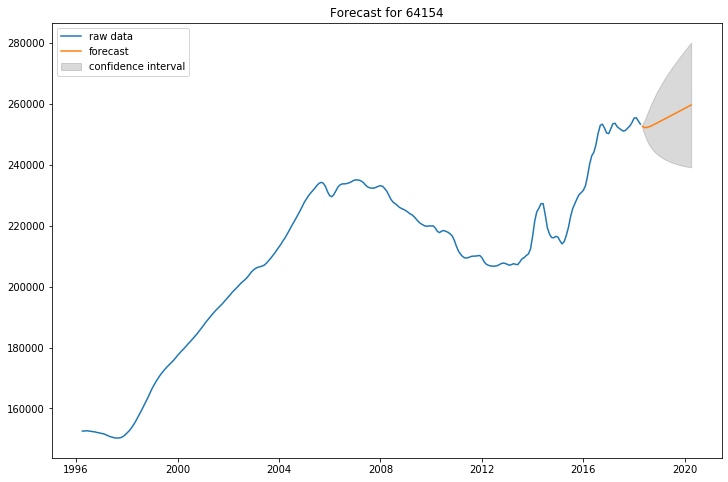

In [33]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_new['value'], label = 'raw data')
plt.plot(df_new['forecast'], label = 'forecast')
plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                label = 'confidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for 64154')

## Get Percent Change in House Price 

In [34]:
# forecasted price after 2 years
forcast_2_years = df_new.loc['2020-04-01', 'forecast']
forcast_lower = df_new.loc['2020-04-01', 'lower_bound']
forcast_upper = df_new.loc['2020-04-01', 'upper_bound']

In [35]:
last_price = df_kc_melt.loc['2018-04-01', 'value']

In [36]:
predicted_percent_change = (forcast_2_years - last_price) / last_price
print(f' I would expect a  {np.round(predicted_percent_change * 100, 4)}% return on my investment in 64154')

 I would expect a  2.4761% return on my investment in 64154


In [37]:
best_percent_change = (forcast_upper - last_price) / last_price
print(f'Best case scenario I would expect a  {np.round(best_percent_change * 100, 4)}% return on my investment in 64154')

Best case scenario I would expect a  10.5515% return on my investment in 64154


In [38]:
worst_percent_change = (forcast_lower - last_price) / last_price
print(f'Worst case scenario I would expect a  {np.round(worst_percent_change * 100, 4)}% return on my investment in 64154')

Worst case scenario I would expect a  -5.5992% return on my investment in 64154
